<a href="https://colab.research.google.com/github/show-kami/FinViz/blob/main/FedOperationVisualizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, date2num
import matplotlib.ticker as ticker
# plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
import requests
from bs4 import BeautifulSoup
import pprint
from datetime import datetime, date, timedelta

# 準備

In [ ]:
def cnvt_time_12to24(string12):
    if string12[-2:] == 'AM':
        return string12[:5]
    elif string12[-2:] == 'PM':
        return str((int(string12[:2]) + 12) % 24) + string12[2:5]

In [ ]:
num = 240  # 過去num回のオペを拾う。最高999回のよう
raw = requests.get(url=f'https://markets.newyorkfed.org/api/tsy/all/results/details/last/{num}.sdmx.xml')
soup = BeautifulSoup(raw.content, 'xml')

print(len(soup.find_all('out:Group')))
print('latest operation date:', soup.find_all('out:Group')[0]['operationDate'])
print('oldest operation date:', soup.find_all('out:Group')[-1]['operationDate'])

240
latest operation date: 2020-12-14
oldest operation date: 2020-03-31


In [ ]:
operationId_lst = []
operationDate_lst = []
maturity_range_start_lst = []
maturity_range_end_lst = []
total_submitted_amount_lst = []
total_purchase_amount_lst = []
weighted_average_maturity_lst = []
purchased_tresuries_dict = {}

for ope in soup.find_all('out:Group'):
    operationId = ope['operationId']
    operationDateTime = ope['operationDate'] + 'T' + cnvt_time_12to24(ope['closeTime'])
    operationDateTime = datetime.strptime(operationDateTime, '%Y-%m-%dT%H:%M')
    maturity_range_start = ope['maturityRangeStart']
    maturity_range_start = datetime.strptime(maturity_range_start, '%Y-%m-%d')
    maturity_range_start_lst.append(maturity_range_start)
    maturity_range_end = ope['maturityRangeEnd']
    maturity_range_end = datetime.strptime(maturity_range_end, '%Y-%m-%d')
    maturity_range_end_lst.append(maturity_range_end)
    total_submitted_amount = ope.find('out:totalAmountSubmitted')['totalParAmtSubmitted']
    total_submitted_amount = float(total_submitted_amount)
    total_submitted_amount_lst.append(total_submitted_amount)
    
    # 各オペで買った債券のデータベース作り
    purchased_cusip_lst = []
    purchased_maturity_lst = []
    purchased_amount_lst = []
    total_purchase_amount = 0
    weighted_average_maturity = timedelta()
    for iss in ope.find_all('out:issue'):
        purchased_cusip_lst.append(iss['cusip'])
        maturity = datetime.strptime(iss['securityDescription'][-8:], '%m/%d/%y')
        if iss['inclusion'] == 'true':
            purchased_maturity_lst.append(maturity)
            amount = int(iss['parAmountAccepted']) / 1e+6
            purchased_amount_lst.append(amount)
            total_purchase_amount += amount
            weighted_average_maturity += amount * (maturity - operationDateTime)
        else:
            purchased_maturity_lst.append(maturity)
            purchased_amount_lst.append(np.nan)
    weighted_average_maturity /= total_purchase_amount
        
    purchased_tresuries_dict[operationId] = pd.DataFrame({
        'maturity': purchased_maturity_lst,
        'amount': purchased_amount_lst
    }, index=purchased_cusip_lst)
    
    # このオペをオペデータベースに格納
    operationId_lst.append(operationId)
    operationDate_lst.append(operationDateTime)
    total_purchase_amount_lst.append(total_purchase_amount)
    weighted_average_maturity_lst.append(weighted_average_maturity.days / 365)
    del operationId, operationDateTime, total_purchase_amount, weighted_average_maturity

operations_db = pd.DataFrame({
    'datetime': operationDate_lst,
    'maturity_range_start': maturity_range_start_lst,
    'maturity_range_end': maturity_range_end_lst,
    'purchase_amount': total_purchase_amount_lst,
    'submitted_amount': total_submitted_amount_lst,
    'wam': weighted_average_maturity_lst
}, index=operationId_lst)
del operationId_lst, operationDate_lst, total_purchase_amount_lst, weighted_average_maturity_lst, \
    purchased_cusip_lst, purchased_maturity_lst, purchased_amount_lst

In [ ]:
operations_db.assign(
    remaining_to_maturity_range_start=lambda df: (df['maturity_range_start'] - df['datetime']).astype('timedelta64[M]') / 12,
    remaining_to_maturity_range_end=lambda df: (df['maturity_range_end'] - df['datetime']).astype('timedelta64[M]') / 12,
).head()

,datetime,maturity_range_start,maturity_range_end,purchase_amount,submitted_amount,wam,remaining_to_maturity_range_start,remaining_to_maturity_range_end
OR 121420 1,2020-12-14 10:30:00,2041-02-15,2050-11-15,1732.0,3920.0,24.800000,20.166667,29.916667
OR 121120 2,2020-12-11 10:30:00,2020-12-15,2023-02-28,12801.0,40676.0,1.435616,0.000000,2.166667
OR 121020 1,2020-12-10 10:30:00,2028-02-15,2040-11-15,3601.0,8890.0,19.632877,7.166667,19.916667
OR 120920 2,2020-12-09 10:30:00,2041-02-15,2050-11-15,1734.0,4230.0,25.000000,20.166667,29.916667
OR 120820 2,2020-12-08 10:30:00,2022-01-15,2028-04-15,2401.0,5777.0,3.342466,1.083333,7.333333


# 買入金額・WAMの時系列

Text(0, 0.5, 'WAM [yr]')

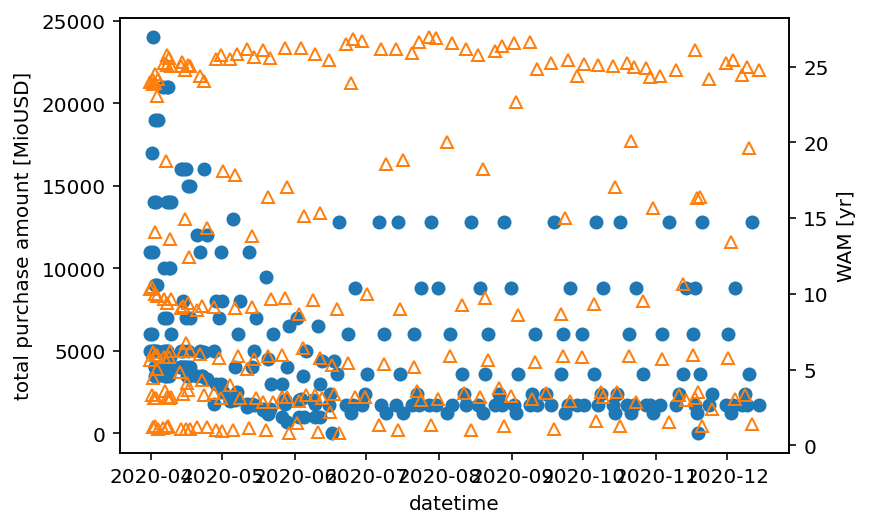

In [ ]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(operations_db['datetime'], operations_db['purchase_amount'], 'o')
ax1.set_xlabel('datetime'); ax1.set_ylabel('total purchase amount [MioUSD]')
# ax1.axvline('2020-04-01', color='k', linestyle='dashed')
ax2 = ax1.twinx()
ax2.plot(operations_db['datetime'], operations_db['wam'], '^', color='none', markeredgecolor='C1', alpha=1)
ax2.set_ylabel('WAM [yr]')
# ax1.set_xlim("2020-01-01", "2020-12-31")

# 買入金額とWAMの関係

Text(0, 0.5, 'total purchase amount [MioUSD]')

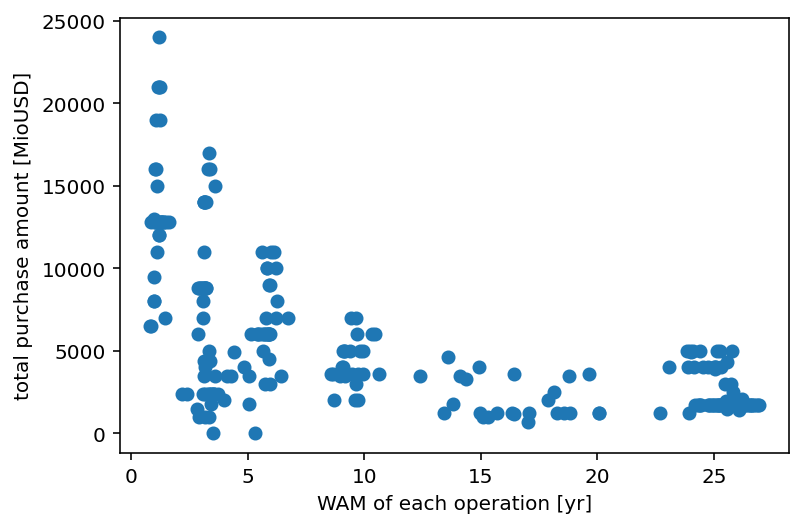

In [ ]:
plt.plot(operations_db['wam'], operations_db['purchase_amount'], 'o')
plt.xlabel('WAM of each operation [yr]'); plt.ylabel('total purchase amount [MioUSD]')

# 各オペの残存年限ごと買入量の積上げ棒グラフ

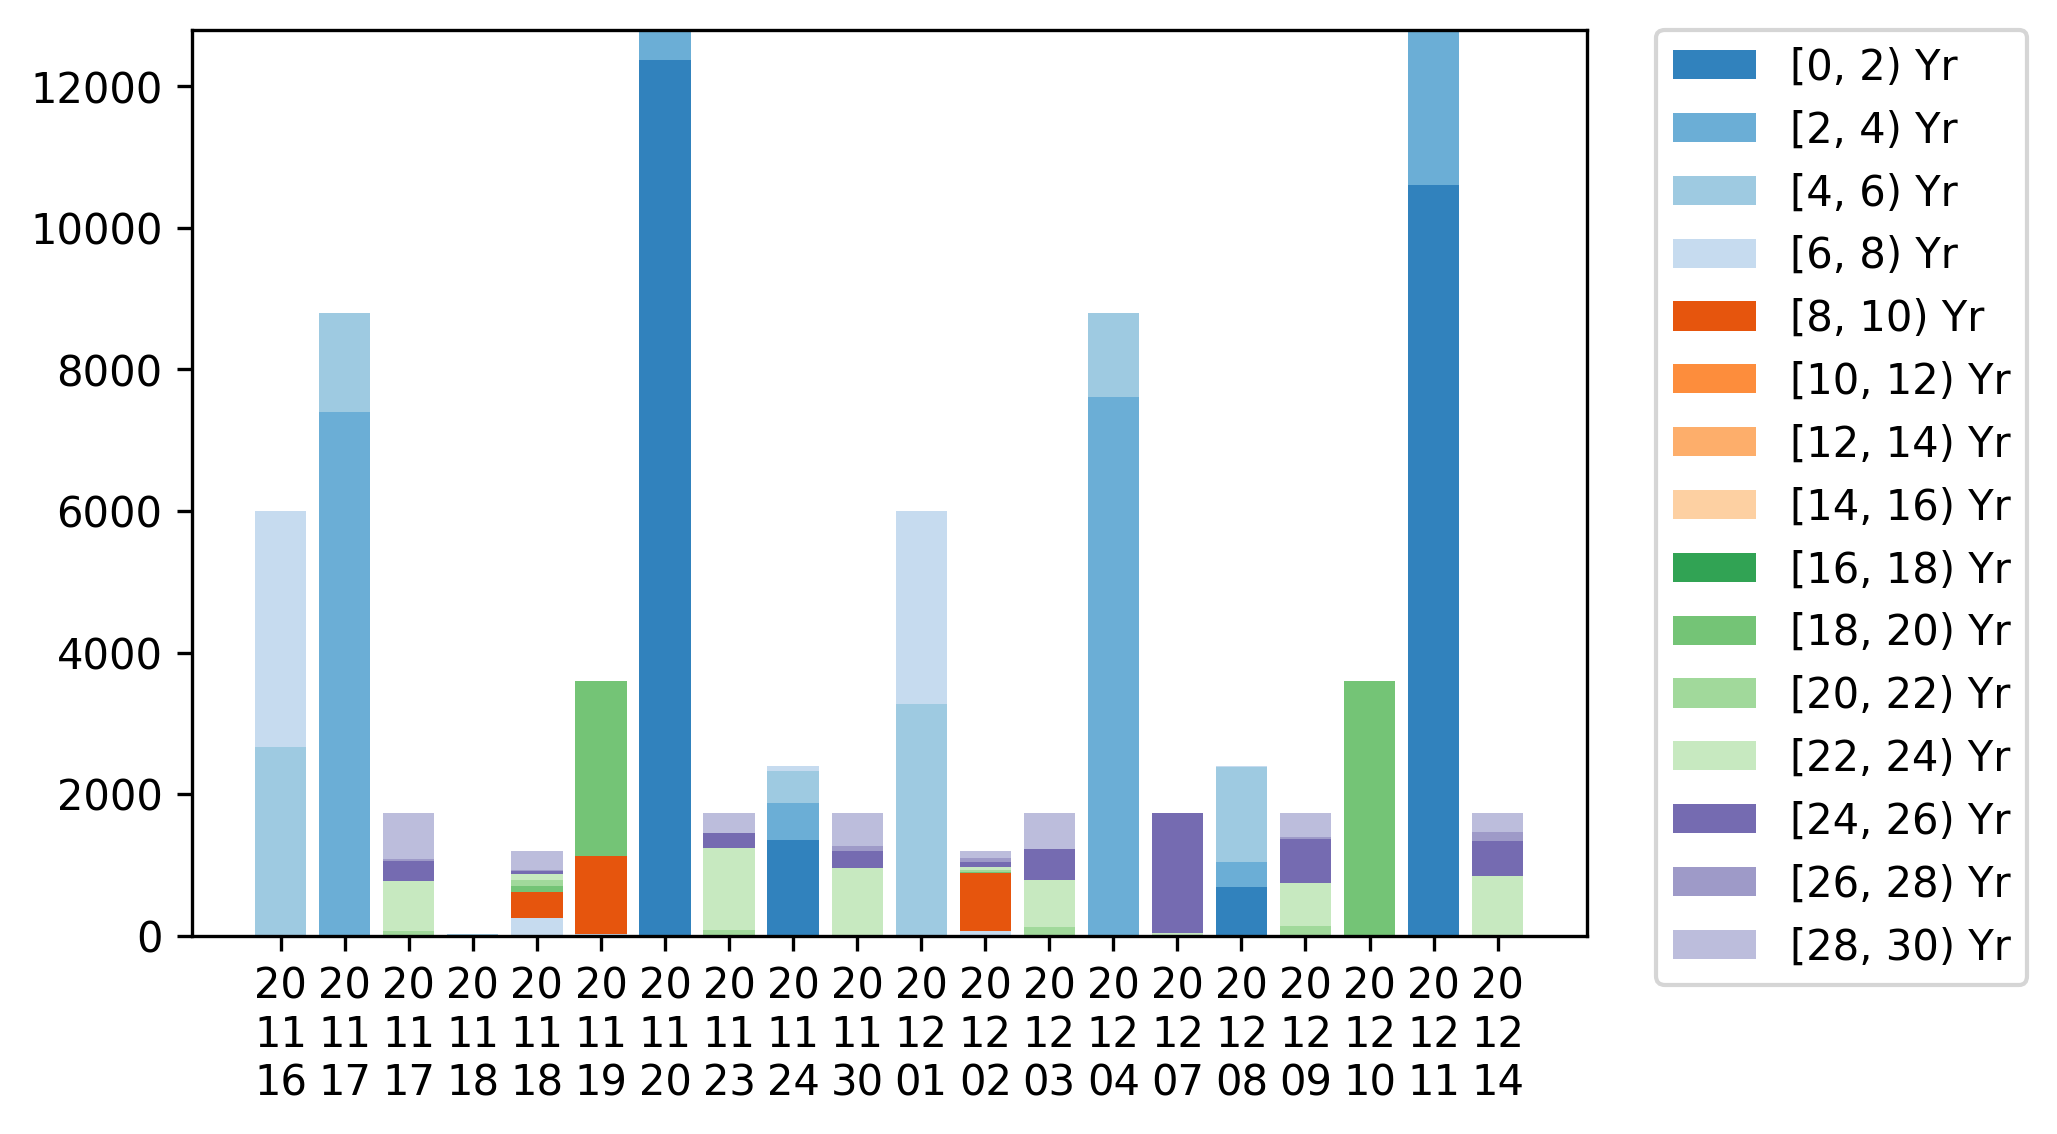

In [ ]:
# 積み上げ棒グラフ作りたい
cmap = plt.get_cmap("tab20c") # ココがポイント
opeids = operations_db.head(20).index
opedate_for_xticklabel = []
for io, opeid in enumerate(opeids[::-1]):
    opedate = operations_db[operations_db.index == opeid]['datetime'][0]
    opedate_for_xticklabel.append(opedate.strftime('%y\n%m\n%d'))
    tmpdf = purchased_tresuries_dict[opeid].assign(
        remain_to_maturity = lambda df: (df['maturity'] - opedate).astype('timedelta64[M]') / 12
    )
    cuts = pd.cut(tmpdf['remain_to_maturity'], np.arange(0, 32, 2), 
                  include_lowest=True, right=False)
    table_by_RemainToMaturity = tmpdf.groupby(cuts).sum()
    for ir, (rangelabel, (amount, trash)) in enumerate(tmpdf.groupby(cuts).sum().iterrows()):
        plt.bar(io, height=table_by_RemainToMaturity.iloc[ir]['amount'],
                bottom=table_by_RemainToMaturity[:ir]['amount'].sum(),
                color=cmap(ir))

# legend用に最後にもう一回同じものを描画
for ir, (rangelabel, (amount, trash)) in enumerate(tmpdf.groupby(cuts).sum().iterrows()):
        plt.bar(io, height=table_by_RemainToMaturity.iloc[ir]['amount'],
                bottom=table_by_RemainToMaturity[:ir]['amount'].sum(),
                color=cmap(ir), label=str(rangelabel)+' Yr')

plt.gca().set_xticks(np.arange(len(opeids)))
plt.gca().set_xticklabels(opedate_for_xticklabel)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.gcf().set_dpi(150)

# 各オペの残存期間ごと買入量　時系列

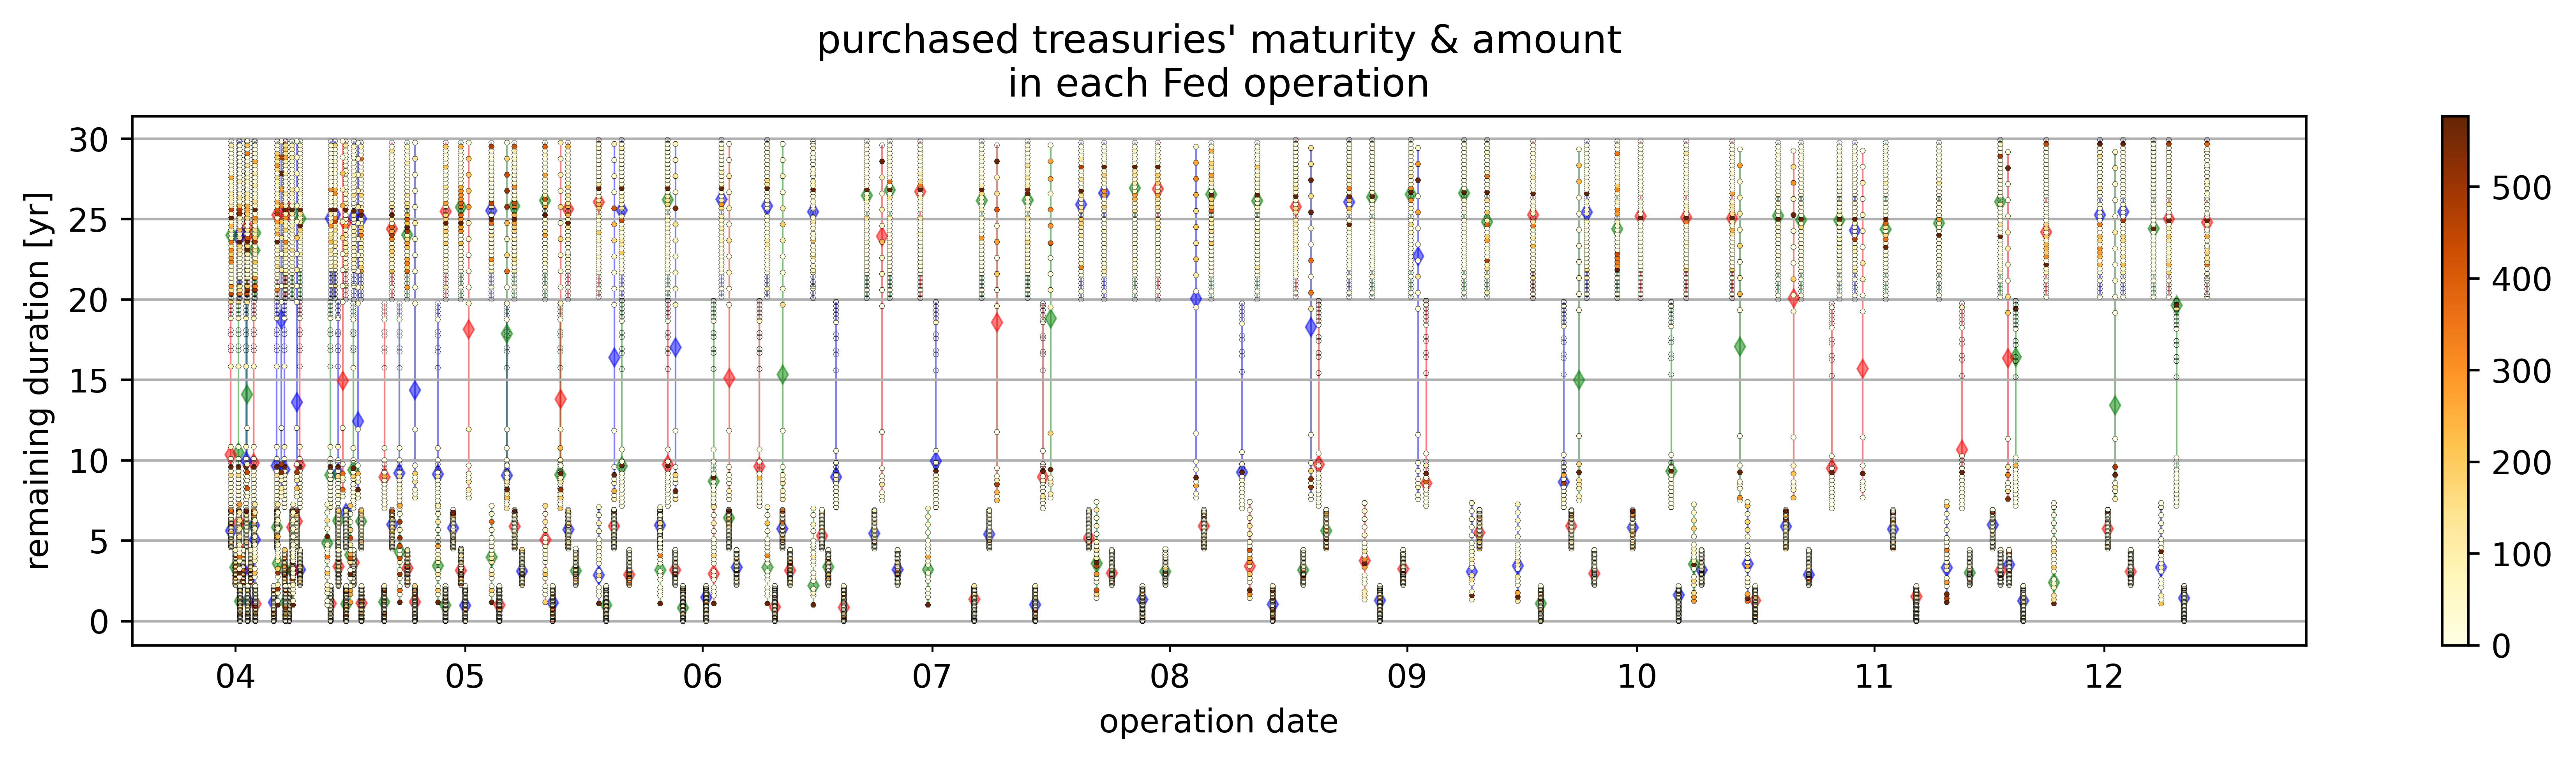

In [ ]:
# オペ実行日-買い入れ残存期間グラフ
fig, ax = plt.subplots(1,1, figsize=(15,3), dpi=300)
fig.set_facecolor('white')
li = 0
for opeid, opedetail in operations_db.iterrows():
    ax.vlines([opedetail['datetime']], 
              ymin=pd.to_timedelta([opedetail['maturity_range_start'] - opedetail['datetime']]).astype('timedelta64[M]') /12,
              ymax=pd.to_timedelta([opedetail['maturity_range_end'] - opedetail['datetime']]).astype('timedelta64[M]') /12,
              linewidth=0.5, color=['red', 'blue', 'green'][li%3],
              alpha=0.5, zorder=1)
    ax.plot(opedetail['datetime'], opedetail['wam'], 'd', 
            color=['red', 'blue', 'green'][li%3], markersize=4, markeredgewidth=0.5, alpha=0.5, zorder=2)
    remaining_duration = purchased_tresuries_dict[opeid]['maturity'] - opedetail['datetime']
    remaining_duration = remaining_duration.astype('timedelta64[M]') / 12
    remaining_duration = pd.Series(remaining_duration, name='remaining_duration')
    num_purchased_tresuries = len(remaining_duration)
    amount_each_purchased = purchased_tresuries_dict[opeid]['amount']
    tmp_df = pd.concat([
#         pd.Series(opedetail['datetime'], index=).repeat(num_purchased_tresuries),
        pd.Series([opedetail['datetime'] for i in range(num_purchased_tresuries)], 
                  index=purchased_tresuries_dict[opeid].index, name='opedatetime'),
        remaining_duration, amount_each_purchased
    ], axis=1)
    img = ax.scatter(tmp_df['opedatetime'].values, tmp_df['remaining_duration'], 
                     c=tmp_df['amount'], cmap='YlOrBr', edgecolors='k', linewidths=0.1,
                     alpha=1, s=3, marker='H', zorder=3)
    li += 1
fig.colorbar(img)
ax.set_xlabel('operation date'); ax.set_ylabel('remaining duration [yr]')
ax.set_title('purchased treasuries\' maturity & amount\nin each Fed operation')


# 時刻軸のフォーマット
months = mdates.MonthLocator()
years = mdates.YearLocator() 
month_fmt = mdates.DateFormatter('%m')
year_fmt = mdates.DateFormatter('%y')
ax.xaxis.set_major_locator(years); ax.xaxis.set_major_formatter(year_fmt)
ax.xaxis.set_minor_locator(months);
ax.xaxis.set_minor_formatter(month_fmt)
ax.grid()